# Instacart Market Basket Analysis


In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
color = sns.color_palette()

from datetime import datetime
import lightgbm as lgb

%matplotlib inline

In [2]:
priors = pd.read_csv('order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.int32,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

train = pd.read_csv('order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.int32,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

orders = pd.read_csv('orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

products = pd.read_csv('products.csv', dtype={
        'product_id': np.int32,
        'aisle_id': np.int16,
        'department_id': np.int16},
        usecols=['product_id', 'aisle_id', 'department_id'])

In [3]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
products.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


### Product features

In [8]:
# product features
p = pd.DataFrame()
p['orders'] = priors.groupby('product_id').size().astype(np.int32)
p['reorders'] = priors['reordered'].groupby(priors.product_id).sum().astype(np.float32)
p['reorder_rate'] = (p.reorders/p.orders).astype(np.float32)

products = products.join(p, on='product_id')
products.set_index('product_id', drop=False, inplace=True)

products.head()

,product_id,aisle_id,department_id,orders,reorders,reorder_rate
product_id,,,,,,
1,1,61,19,1852.0,1136.0,0.613391
2,2,104,13,90.0,12.0,0.133333
3,3,94,7,277.0,203.0,0.732852
4,4,38,1,329.0,147.0,0.446809
5,5,5,13,15.0,9.0,0.600000


In [9]:
del p

In [10]:
# add info to priors
orders_pr = orders[orders['eval_set'] == 'prior']
orders_pr.set_index('order_id', inplace=True, drop=False)
priors = priors.merge(orders_pr, on='order_id', how='left')

priors.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'order_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  after removing the cwd from sys.path.


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


### User features

In [11]:
# user features
u = pd.DataFrame()
u['total_orders'] = orders_pr.groupby('user_id').size().astype(np.int16)
u['avg_days_btw_orders'] = orders_pr.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
u['median_days_btw_orders'] = orders_pr.groupby('user_id')['days_since_prior_order'].median().astype(np.float32)

u2 = pd.DataFrame()
u2['total_items'] = priors.groupby('user_id').size().astype(np.int16)
u2['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
u2['distinct_items'] = (u2.all_products.map(len)).astype(np.int16)

users = u2.join(u)

users['avg_basket'] = (users.total_items/users.total_orders).astype(np.float32)
users['avg_distinct_basket'] = (users.distinct_items/users.total_orders).astype(np.float32)

del u, u2
users.head()

,total_items,all_products,distinct_items,total_orders,avg_days_btw_orders,median_days_btw_orders,avg_basket,avg_distinct_basket
user_id,,,,,,,,
1,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18,10,19.555555,20.0,5.900000,1.800000
2,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102,14,15.230769,13.0,13.928572,7.285714
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,12,12.090909,11.0,7.333333,2.750000
4,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17,5,13.750000,17.0,3.600000,3.400000
5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23,4,13.333333,11.0,9.250000,5.750000


### UserXProduct features

In [12]:
# userXproduct features
priors['user_product'] = priors.product_id + priors.user_id * 100000
d = {}

for row in priors.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1, 
                (row.order_number, row.order_id), 
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0]+1,
                max(d[z][1], (row.order_number, row.order_id)), 
                d[z][2]+row.add_to_cart_order)

up = pd.DataFrame.from_dict(d, orient='index')
up.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']

del d

up.nb_orders = up.nb_orders.astype(np.int16)
up.last_order_id = up.last_order_id.map(lambda x: x[1]).astype(np.int32)
up.sum_pos_in_cart = up.sum_pos_in_cart.astype(np.int16)

up.head(10)

,nb_orders,last_order_id,sum_pos_in_cart
20227933120,5,104690,10
20227928985,5,132412,16
20227909327,1,2,3
20227945918,5,2382766,24
20227930035,3,2382766,14
20227917794,7,2382766,25
20227940141,5,132412,29
20227901819,2,2,19
20227943668,3,132412,20
20597033754,17,368699,86


## Features based on recent 5 orders

In [14]:
# take recent 5 orders of each user
orders_n5 = orders_pr.groupby('user_id').order_number.nlargest(5).to_frame().reset_index()
orders_n5.head(10)

priors_n5 = priors.merge(orders_n5, 
                         on=['order_id','user_id','order_number'], how='inner')
priors_n5.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product
0,6,40462,1,0,22352,prior,4,1,12,30.0,2235240462
1,6,15873,2,0,22352,prior,4,1,12,30.0,2235215873
2,6,41897,3,0,22352,prior,4,1,12,30.0,2235241897
3,7,34050,1,0,142903,prior,11,2,14,30.0,14290334050
4,7,46802,2,0,142903,prior,11,2,14,30.0,14290346802
5,12,30597,1,1,152610,prior,22,6,8,10.0,15261030597
6,12,15221,2,1,152610,prior,22,6,8,10.0,15261015221
7,12,43772,3,1,152610,prior,22,6,8,10.0,15261043772
8,12,37886,4,1,152610,prior,22,6,8,10.0,15261037886
9,12,37215,5,0,152610,prior,22,6,8,10.0,15261037215


### User features of nearest 5 orders

In [15]:
# user features of nearest 5 orders
orders_n5 = orders_n5.merge(orders_pr, 
                            on=['order_id','user_id','order_number'], how='inner')
u = pd.DataFrame()
u['total_orders'] = orders_n5.groupby('user_id').size().astype(np.int16)
u['avg_days_btw_orders'] = orders_n5.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
u['median_days_btw_orders'] = orders_n5.groupby('user_id')['days_since_prior_order'].median().astype(np.float32)

u2 = pd.DataFrame()
u2['total_items'] = priors_n5.groupby('user_id').size().astype(np.int16)
u2['all_products'] = priors_n5.groupby('user_id')['product_id'].apply(set)
u2['distinct_items'] = (u2.all_products.map(len)).astype(np.int16)
del u2['all_products']

users_n5 = u2.join(u)
users_n5['avg_basket'] = (users_n5.total_items/users_n5.total_orders).astype(np.float32)
users_n5['avg_distinct_basket'] = (users_n5.distinct_items/users_n5.total_orders).astype(np.float32)

del u, u2
users_n5.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'order_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,total_items,distinct_items,total_orders,avg_days_btw_orders,median_days_btw_orders,avg_basket,avg_distinct_basket
user_id,,,,,,,
1,30,10,5,16.600000,19.0,6.00,2.00
2,68,46,5,21.400000,28.0,13.60,9.20
3,30,14,5,11.400000,11.0,6.00,2.80
4,18,17,5,13.750000,17.0,3.60,3.40
5,37,23,4,13.333333,11.0,9.25,5.75


### UserXProduct features of nearest 5 orders

In [16]:
# userXproduct features of nearest 5 orders
d = {}

for row in priors_n5.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1, 
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0]+1,
                d[z][1]+row.add_to_cart_order)

up_n5 = pd.DataFrame.from_dict(d, orient='index')
up_n5.columns = ['nb_orders', 'sum_pos_in_cart']

del d

up_n5.nb_orders = up_n5.nb_orders.astype(np.int16)
up_n5.sum_pos_in_cart = up_n5.sum_pos_in_cart.astype(np.int16)

up_n5.head(10)

,nb_orders,sum_pos_in_cart
2235240462,1,1
2235215873,1,2
2235241897,1,3
14290334050,1,1
14290346802,1,2
15261030597,1,1
15261015221,2,5
15261043772,1,3
15261037886,1,4
15261037215,1,5


## Feature engineering

In [17]:
# train test orders
train_orders = orders[orders.eval_set == 'train']
test_orders = orders[orders.eval_set == 'test']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

In [18]:
def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.total_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['user_distinct_items'] = df.user_id.map(users.distinct_items)
    df['user_avg_days_btw_orders'] = df.user_id.map(users.avg_days_btw_orders)
    df['user_median_days_btw_orders'] = df.user_id.map(users.median_days_btw_orders)
    df['user_avg_basket'] =  df.user_id.map(users.avg_basket)
    
    df['user_total_orders_n5'] = df.user_id.map(users_n5.total_orders)
    df['user_total_items_n5'] = df.user_id.map(users_n5.total_items)
    df['user_distinct_items_n5'] = df.user_id.map(users_n5.distinct_items)
    df['user_avg_days_btw_orders_n5'] = df.user_id.map(users_n5.avg_days_btw_orders)
    df['user_median_days_btw_orders_n5'] = df.user_id.map(users_n5.median_days_btw_orders)
    df['user_avg_basket_n5'] =  df.user_id.map(users_n5.avg_basket)

    print('order related features')
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_avg_days_btw_orders
    
    df['days_since_ratio_n5'] = df.days_since_prior_order / df.user_avg_days_btw_orders_n5
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(up.nb_orders)
    df['UP_last_order_id'] = df.z.map(up.last_order_id)
    df['UP_avg_pos_in_cart'] = (df.z.map(up.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
#    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    
    df['UP_orders_n5'] = df.z.map(up_n5.nb_orders)
    df['UP_avg_pos_in_cart_n5'] = (df.z.map(up_n5.sum_pos_in_cart) / df.UP_orders_n5).astype(np.float32)
    df['UP_reorder_rate_n5'] = (df.UP_orders_n5 / df.user_total_orders_n5).astype(np.float32)
    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

In [ ]:
X_train, labels = features(train_orders, labels_given=True)

In [22]:
y_train = pd.DataFrame(labels, columns=['label'])
train = pd.concat([X_train, y_train], axis=1)
train.to_pickle('train.pkl')

In [ ]:
X_test, _ = features(test_orders)

X_test.to_pickle('test.pkl')

### Overall behaviors vs recent 5 orders 
- Users' recent shopping behaviors (recent 5 orders) are correlated with their overall shopping behavior (0.7-0.9), but not exactly same.   
- Especially with regard to product reorder rate, correlation between UP_reorder_rate and UP_reorder_rate_n5 is 0.7, lowest of all.

In [25]:
# all orders vs nearest 5 orders
print('UP_reorder_rate', 'UP_reorder_rate_n5', corrmat['UP_reorder_rate']['UP_reorder_rate_n5'])
print('user_avg_days_btw_orders', 'user_avg_days_btw_orders_n5', corrmat['user_avg_days_btw_orders']['user_avg_days_btw_orders_n5'])
print('user_avg_basket', 'user_avg_basket_n5', corrmat['user_avg_basket']['user_avg_basket_n5'])
print('days_since_ratio', 'days_since_ratio_n5', corrmat['days_since_ratio']['days_since_ratio_n5'])
print('UP_avg_pos_in_cart', 'UP_avg_pos_in_cart_n5', corrmat['UP_avg_pos_in_cart']['UP_avg_pos_in_cart_n5'])

UP_reorder_rate UP_reorder_rate_n5 0.7084104047544123
user_avg_days_btw_orders user_avg_days_btw_orders_n5 0.8991115338270881
user_avg_basket user_avg_basket_n5 0.9078683036790905
days_since_ratio days_since_ratio_n5 0.8209298473885959
UP_avg_pos_in_cart UP_avg_pos_in_cart_n5 0.8650148648311861


## Modeling

In [26]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(X_train, labels, 
                                            test_size=0.20, random_state=23)

In [198]:
feat = ['user_total_orders', 'user_total_items','user_distinct_items', 
        'user_avg_days_btw_orders','user_avg_basket', 
        'user_total_orders_n5', 'user_distinct_items_n5', 
        'user_avg_days_btw_orders_n5','user_avg_basket_n5', 
        'order_hour_of_day','days_since_prior_order', 'days_since_ratio', 
        'days_since_ratio_n5', 'aisle_id', 'department_id',
        'product_orders', 'product_reorders', 'product_reorder_rate',
        'UP_orders', 'UP_avg_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last', 
        'UP_orders_n5', 'UP_reorder_rate_n5', 'UP_avg_pos_in_cart_n5']

lgb12_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 112,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5}

lgbtrain = lgb.Dataset(x_tr[feat], y_tr)
lgbvalid = lgb.Dataset(x_val[feat], y_val)

ROUNDS = 100
#early_stopping = 100
lgb12 = lgb.train(lgb12_params, 
                lgbtrain,
                num_boost_round=ROUNDS,
                valid_sets=[lgbvalid],
                categorical_feature=['aisle_id', 'department_id'],
#                early_stopping_rounds=early_stopping,
                verbose_eval=20)

/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['aisle_id', 'department_id']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[20]	valid_0's binary_logloss: 0.302669
[40]	valid_0's binary_logloss: 0.302107
[60]	valid_0's binary_logloss: 0.301872
[80]	valid_0's binary_logloss: 0.301678
[100]	valid_0's binary_logloss: 0.301521


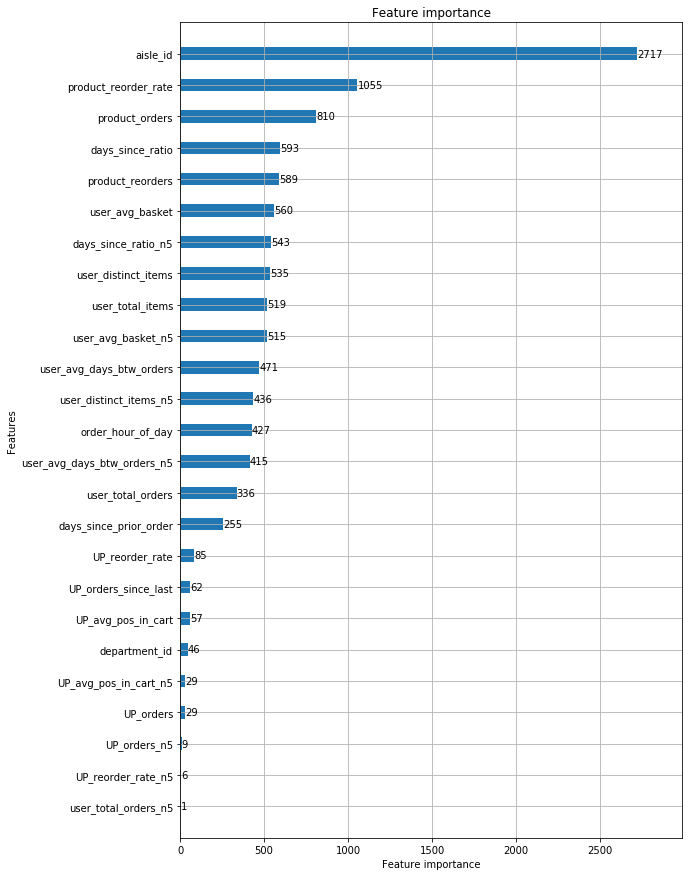

In [203]:
lgb.plot_importance(lgb12, figsize=(9,15), height=0.4)

In [199]:
test_preds['lgb12_test'] = lgb12.predict(X_test)

THRESHOLD = 0.2

d = {}
for row in test_preds.itertuples():
    if row.lgb12_test >= THRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)
        

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'   

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub_lgb12.csv', index=False)

# F1 score: 0.1900706

## F1 score optimization

In [137]:
# Author: @Faron

class F1Optimizer():
    def __init__(self):
        pass

    @staticmethod
    def get_expectations(P, pNone=None):
        expectations = []
#        P = np.sort(P)[::-1]

        n = np.array(P).shape[0]
        DP_C = np.zeros((n + 2, n + 1))
        if pNone is None:
            pNone = (1.0 - P).prod()

        DP_C[0][0] = 1.0
        for j in range(1, n):
            DP_C[0][j] = (1.0 - P[j - 1]) * DP_C[0, j - 1]

        for i in range(1, n + 1):
            DP_C[i, i] = DP_C[i - 1, i - 1] * P[i - 1]
            for j in range(i + 1, n + 1):
                DP_C[i, j] = P[j - 1] * DP_C[i - 1, j - 1] + (1.0 - P[j - 1]) * DP_C[i, j - 1]

        DP_S = np.zeros((2 * n + 1,))
        DP_SNone = np.zeros((2 * n + 1,))
        for i in range(1, 2 * n + 1):
            DP_S[i] = 1. / (1. * i)
            DP_SNone[i] = 1. / (1. * i + 1)
        for k in range(n + 1)[::-1]:
            f1 = 0
            f1None = 0
            for k1 in range(n + 1):
                f1 += 2 * k1 * DP_C[k1][k] * DP_S[k + k1]
                f1None += 2 * k1 * DP_C[k1][k] * DP_SNone[k + k1]
            for i in range(1, 2 * k - 1):
                DP_S[i] = (1 - P[k - 1]) * DP_S[i] + P[k - 1] * DP_S[i + 1]
                DP_SNone[i] = (1 - P[k - 1]) * DP_SNone[i] + P[k - 1] * DP_SNone[i + 1]
            expectations.append([f1None + 2 * pNone / (2 + k), f1])

        return np.array(expectations[::-1]).T

    @staticmethod
    def maximize_expectation(P, pNone=None):
        expectations = F1Optimizer.get_expectations(P, pNone)

        ix_max = np.unravel_index(expectations.argmax(), expectations.shape)
        max_f1 = expectations[ix_max]

        predNone = True if ix_max[0] == 0 else False
        best_k = ix_max[1]

        return best_k, predNone, max_f1

    @staticmethod
    def _F1(tp, fp, fn):
        return 2 * tp / (2 * tp + fp + fn)

    @staticmethod
    def _Fbeta(tp, fp, fn, beta=1.0):
        beta_squared = beta ** 2
        return (1.0 + beta_squared) * tp / ((1.0 + beta_squared) * tp + fp + beta_squared * fn)
    

def get_best_prediction(P, L, pNone=None):
#    print("Maximize F1-Expectation")
#    print("=" * 23)
#    P = np.sort(P)[::-1]
    n = P.shape[0]
#    L = ['L{}'.format(i + 1) for i in range(n)]

    if pNone is None:
#        print("Estimate p(None|x) as (1-p_1)*(1-p_2)*...*(1-p_n)")
        pNone = (1.0 - P).prod()

#    PL = ['p({}|x)={}'.format(l, p) for l, p in zip(L, P)]
#    print("Posteriors: {} (n={})".format(PL, n))
#    print("p(None|x)={}".format(pNone))

    opt = F1Optimizer.maximize_expectation(P, pNone)
    best_prediction = []
    if opt[1]: best_prediction.append('None')
    for l in L[:opt[0]]: best_prediction.append(l)
    f1_max = opt[2]
    
    return best_prediction

In [144]:
def optimize_f1score(model_prediction):
    tmp = X_test[['order_id', 'product_id']]
    tmp['pred'] = model_prediction
    tmp = tmp.sort_values(by=['order_id', 'pred'], ascending=False)
    tmp['product_id'] = tmp['product_id'].astype(str)
    l = tmp.groupby('order_id')['product_id'].apply(list).to_frame().reset_index()
    p = tmp.groupby('order_id')['pred'].apply(np.array).to_frame().reset_index()
    df = l.merge(p, on='order_id', how='left')

    d={}
    for row in df.itertuples():
        P=row.pred
        L=row.product_id
        d[row.order_id] = " ".join(get_best_prediction(P,L))
    
    sub = pd.DataFrame.from_dict(d, orient='index')
    sub.reset_index(inplace=True)
    sub.columns = ['order_id', 'products']
    return sub

In [202]:
sub_lgb12_opt = optimize_f1score(test_preds['lgb12_test'])
sub_lgb12_opt.to_csv('sub_lgb12_opt.csv', index=False)

# F1 score: 0.2092306

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### To be done
- LGBM model tuning
- Try more classification models
- CV